### Классификация изображений художников разного стиля с использованием `PyTorch`

Импорт библиотек:

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
#import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import precision_recall_fscore_support

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Определяем трансформацию изображений: отдельно для тренировочного набора с аугментацией данных и отдельно для тестового и валидационного.

In [2]:
# define default transormation

val_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# randop crop
train_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
#     transforms.RandomGrayscale(p=0.2),
#     transforms.RandomRotation(30),
    #transforms.GaussianNoise(0.1),

    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #transforms.Normalize()
    #transforms.Normalize(mean, std)

])

Загрузка изображений, которые хранятся в директории `images` 

In [3]:
image_dataset = torchvision.datasets.ImageFolder('images', transform=val_transform)

Разбиваем изображения на трейновый, валидационный и тестовый набор (70%, 20%, 10%) без стратификации. Оказалось, что это работает хуже чем со стратификацией с учетом размеров классов 

In [4]:
# train_size = int(0.7 * len(image_dataset))
# val_size = int(0.2 * len(image_dataset))
# test_size = len(image_dataset) - train_size - val_size
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size, test_size])
# # realize data augmentation for train set
# train_dataset.dataset.transform = train_transform


In [5]:
# print("Train set size: {:}, validation set size: {:}, test set size: {:}".format(train_size, val_size, test_size))

# print(train_size)
# print(val_size)
# print(test_size)
# print(train_dataset.dataset)

In [6]:
# загрузка данных соответствующего размера
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Разбиваем изображения на трейновый, валидационный и тестовый набор с учетом размеров классов.

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the labels for each image
labels = [image_dataset[i][1] for i in range(len(image_dataset))]

# Create the stratified shuffle split object
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3)

# Split the indices of the images into train and validation-test sets
for train_index, test_valid_index in split.split(range(len(image_dataset)), labels):
    train_dataset = torch.utils.data.Subset(image_dataset, train_index)
    test_valid_dataset = torch.utils.data.Subset(image_dataset, test_valid_index)

# Create a second stratified shuffle split object for the train set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.4)

# Split the indices of the train set into train and validation sets
for val_index, test_index in split.split(range(len(test_valid_dataset)), [test_valid_dataset[i][1] for i in range(len(test_valid_dataset))]):
    test_dataset = torch.utils.data.Subset(test_valid_dataset, test_index)
    val_dataset = torch.utils.data.Subset(test_valid_dataset, val_index)


In [8]:
# загрузка данных соответствующего размера
train_dataset.dataset.transform = train_transform
print(train_dataset.dataset)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Dataset ImageFolder
    Number of datapoints: 1422
    Root location: images
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [9]:
print("Train set size: {:}, validation set size: {:}, test set size: {:}".format(train_index.size, val_index.size, test_index.size))

Train set size: 995, validation set size: 256, test set size: 171


Проверим результат разбиения по классам

In [10]:
def count_classes(dataloader):
    labels_count = defaultdict(int)
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        for label in labels:
            labels_count[label.item()] += 1
    return(labels_count)

data = {'Train set': count_classes(train_dataloader),
        'Validation set': count_classes(val_dataloader),
        'Test set': count_classes(test_dataloader)}
print(data)

{'Train set': defaultdict(<class 'int'>, {4: 153, 7: 97, 5: 82, 1: 255, 3: 142, 2: 168, 0: 46, 6: 52}), 'Validation set': defaultdict(<class 'int'>, {0: 11, 4: 39, 1: 66, 3: 37, 6: 14, 2: 43, 5: 21, 7: 25}), 'Test set': defaultdict(<class 'int'>, {7: 17, 3: 24, 4: 26, 0: 8, 1: 44, 2: 29, 5: 14, 6: 9})}


In [11]:
for i, group in enumerate(data.keys()):
    print(group)
    keys = list(data[group].keys())
    print(keys)
    print(list(data[group].values()))

Train set
[4, 7, 5, 1, 3, 2, 0, 6]
[153, 97, 82, 255, 142, 168, 46, 52]
Validation set
[0, 4, 1, 3, 6, 2, 5, 7]
[11, 39, 66, 37, 14, 43, 21, 25]
Test set
[7, 3, 4, 0, 1, 2, 5, 6]
[17, 24, 26, 8, 44, 29, 14, 9]


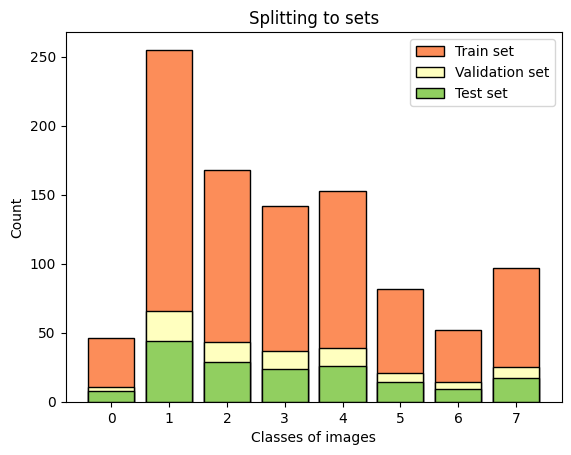

In [12]:
colors = ['#fc8d59', '#ffffbf', '#91cf60']

for i, group in enumerate(data.keys()):
    keys = list(data[group].keys())
    values = list(data[group].values())
    plt.bar(keys, values, edgecolor='black', color=colors[i], label=group)

plt.xlabel('Classes of images')
plt.ylabel('Count')
plt.title('Splitting to sets')
plt.legend()
plt.show()

Определяем модель для классификации изображений: resnet с 18 слоями, задаем на полносвязном уровне количество наших классов 

In [13]:
model = torchvision.models.resnet18(weights=True)
#model = torchvision.models.resnet50(weights=True)

model.fc = nn.Linear(512, len(image_dataset.classes))
# model.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.2, training=m.training))
#model.fc.register_forward_hook(lambda m, inp, out: nn.Softmax(out))
#model.fc = nn.Sequential(
 #   nn.Linear(512, len(image_dataset.classes)),
  #  nn.Softmax())
#model.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.2, training=m.training))


C:\Users\elena\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# from torchvision.models.feature_extraction import get_graph_node_names
# from torchvision.models import resnet50

# train_nodes, eval_nodes = get_graph_node_names(resnet50())
# print(train_nodes)
# print(eval_nodes)

Выбираю функцию ошибки CrossEntropyLoss, поскольку у нас задача классификации нескольких классов. Стохастический градиентный спуск показал самый лучший результат в этой задаче


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters())
# optimizer = optim.RMSprop(model.parameters()) # this optimizer functioned really bad

In [16]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

Задаем функцию для проверки валидационного и тестого сета, чтобы не дублировать код

In [17]:
def validate(curr_model, dataloader, criterion):
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            outputs = curr_model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        val_loss = running_loss / len(dataloader)
        val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [18]:
num_epochs = 15
best_accuracy = 0
best_loss = float('inf')
best_epoch = 0

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Record the loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate the average loss and accuracy for the epoch
    train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validate the model
    val_loss, val_accuracy = validate(model, val_dataloader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print("Epoch {}/{} - Train Loss: {:.4f} - Train Accuracy: {:.2f}% - Val Loss: {:.4f} - Val Accuracy: {:.2f}%".format(
        epoch + 1, num_epochs, train_loss, train_accuracy, val_loss, val_accuracy))
    if val_accuracy > best_accuracy or (val_accuracy == best_accuracy and val_loss < best_loss):
        best_accuracy = val_accuracy
        best_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pt')

Epoch 1/15 - Train Loss: 1.8771 - Train Accuracy: 31.66% - Val Loss: 1.6533 - Val Accuracy: 43.75%
Epoch 2/15 - Train Loss: 0.9927 - Train Accuracy: 69.05% - Val Loss: 1.5212 - Val Accuracy: 49.22%
Epoch 3/15 - Train Loss: 0.6271 - Train Accuracy: 83.42% - Val Loss: 1.4359 - Val Accuracy: 51.17%
Epoch 4/15 - Train Loss: 0.4430 - Train Accuracy: 89.45% - Val Loss: 1.3742 - Val Accuracy: 56.64%
Epoch 5/15 - Train Loss: 0.2695 - Train Accuracy: 94.97% - Val Loss: 1.3529 - Val Accuracy: 57.03%
Epoch 6/15 - Train Loss: 0.2160 - Train Accuracy: 97.39% - Val Loss: 1.4233 - Val Accuracy: 55.47%
Epoch 7/15 - Train Loss: 0.1924 - Train Accuracy: 97.69% - Val Loss: 1.4580 - Val Accuracy: 53.52%
Epoch 8/15 - Train Loss: 0.2300 - Train Accuracy: 96.18% - Val Loss: 1.5327 - Val Accuracy: 57.03%
Epoch 9/15 - Train Loss: 0.1460 - Train Accuracy: 97.79% - Val Loss: 1.5440 - Val Accuracy: 54.69%
Epoch 10/15 - Train Loss: 0.1281 - Train Accuracy: 97.89% - Val Loss: 1.5207 - Val Accuracy: 54.69%
Epoch 11/

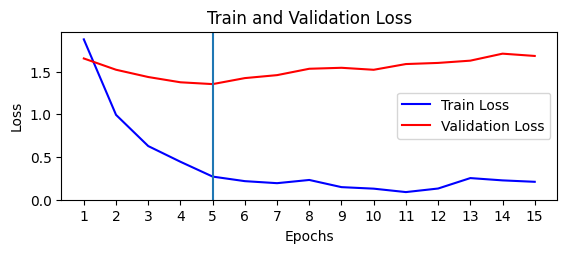

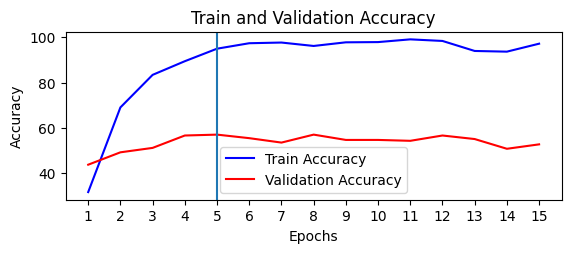

In [19]:
epochs = range(1, num_epochs + 1)
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs+1))
plt.legend()
plt.axvline(x = best_epoch+1, linestyle = '-')
plt.show()

plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracies, 'b', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xticks(range(1, num_epochs+1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.axvline(x = best_epoch+1, linestyle = '-')
plt.show()


#plt.plt(train_losses, val_losses)

In [20]:
# best_model = models.resnet.ResNet(...)
model.load_state_dict(torch.load('best_model.pt'))
# print(model)
test_loss, test_accuracy = validate(model, test_dataloader, criterion)
print(best_epoch+1)
print("Test Loss: {:.4f}, Test Accuracy: {:.2f}% in the epoch {:}".format(test_loss, test_accuracy, best_epoch+1))

5
Test Loss: 1.5243, Test Accuracy: 53.22% in the epoch 5


In [21]:
# print(model)
# type(best_model)
# type(model)
# print(best_model.__class_)

Почему использовали F1 score взвешенный

In [22]:
# Initialize the confusion matrix

confusion_matrix = torch.zeros(len(image_dataset.classes), len(image_dataset.classes), dtype=torch.int64)

# Initialize the lists to store the true labels and predicted labels for the test set
true_labels = []
pred_labels = []

# Evaluation mode
model.eval()

# Set the gradient computation to be off
with torch.no_grad():
    # Iterate over the test data
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        
        # Append the true labels and predicted labels to the lists
        true_labels.extend(labels.tolist())
        pred_labels.extend(preds.tolist())
        
        # Increment the count in the corresponding cells of the confusion matrix
        for t, p in zip(labels, preds):
            confusion_matrix[t, p] += 1

# Compute the precision, recall and f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')
precision_macro, recall_macro, f1_score_macro, _ = precision_recall_fscore_support(true_labels, pred_labels, average='macro')

# Print the test loss, test accuracy and f1-score
print("Weighted Test Loss: {:.4f} - Test Accuracy: {:.2f}% - Test F1-Score: {:.2f}".format(test_loss, test_accuracy, f1_score))
print("Macro Test Loss: {:.4f} - Test Accuracy: {:.2f}% - Test F1-Score: {:.2f}".format(test_loss, test_accuracy, f1_score_macro))

Weighted Test Loss: 1.5243 - Test Accuracy: 53.22% - Test F1-Score: 0.56
Macro Test Loss: 1.5243 - Test Accuracy: 53.22% - Test F1-Score: 0.53


In [23]:
print(confusion_matrix)
print(f1_score)


tensor([[ 3,  2,  0,  1,  0,  1,  0,  1],
        [ 1, 33,  4,  3,  1,  0,  0,  2],
        [ 0,  7, 13,  2,  4,  1,  1,  1],
        [ 0,  3,  6,  9,  3,  0,  1,  2],
        [ 1,  1,  3,  2, 18,  1,  0,  0],
        [ 0,  1,  0,  0,  1, 11,  0,  1],
        [ 0,  2,  0,  2,  0,  0,  3,  2],
        [ 1,  5,  1,  1,  0,  2,  0,  7]])
0.5575438603314898


In [24]:
print(precision)
print(recall)

0.5581735975741824
0.5672514619883041


In [25]:
print(train_losses)
print(train_accuracies)
print(val_losses)
print(val_accuracies)

[1.8771049492061138, 0.9927357919514179, 0.6270557474344969, 0.44301111809909344, 0.26945483731105924, 0.21604778710752726, 0.1923534816596657, 0.23001737613230944, 0.14599378465209156, 0.12809927109628916, 0.08796077611623332, 0.12972393061500043, 0.25199153111316264, 0.22509247064590454, 0.20839921245351434]
[31.65829145728643, 69.04522613065326, 83.41708542713567, 89.44723618090453, 94.9748743718593, 97.38693467336684, 97.68844221105527, 96.18090452261306, 97.78894472361809, 97.8894472361809, 99.09547738693468, 98.39195979899498, 93.96984924623115, 93.66834170854271, 97.1859296482412]
[1.653298795223236, 1.5211814641952515, 1.435947135090828, 1.3741685450077057, 1.3529218137264252, 1.4232636839151382, 1.458046406507492, 1.5326827615499496, 1.5440241396427155, 1.5207260847091675, 1.5878389924764633, 1.6010703444480896, 1.6276099681854248, 1.7095051258802414, 1.6827642172574997]
[43.75, 49.21875, 51.171875, 56.640625, 57.03125, 55.46875, 53.515625, 57.03125, 54.6875, 54.6875, 54.29687